# Logística de envíos: ¿Cuándo llega?

## Mentoría DiploDatos 2019 

### Integrantes:

- Chaves, Noelia
- Frau, Johanna

### Mentora:

- Dal Lago, Virginia

### Práctico: Análisis exploratorio y curación

## Motivación

En la actualidad, cada vez más productos se comercializan a través de una plataforma online. Una de las principales ventajas de este sistema es que el usuario puede recibir el producto en su domicilio en una fecha determinada. Pero, ¿cómo sabemos qué día va a llegar? ¿A partir de qué datos podemos predecir la demora del envío? En este práctico se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, analizando y modelando el problema de logística de envíos para poder responder ¿cuándo llega?

## Descripción del dataset

**Datos:**  El conjunto de datos seleccionado para realizar el práctico corresponde a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre Octubre de 2018 y Abril de 2019 (las fechas originales han sido modificadas y adaptadas a un período de tiempo diferente, conservando el día de la semana y considerando los feriados correspondientes). Mientras que las fechas han sido modificadas, los horarios registrados en el dataset son los originales. Los datos comprenden variables tanto categóricas como numéricas. 

El dataset cuenta con las siguientes columnas:

- **Sender_state:** Estado de Brasil de donde sale el envío.
- **Sender_zipcode:** Código postal (de 5 dígitos) de donde sale el envío.
- **Receiver_state:** Estado de Brasil a donde llega el envío.
- **Receiver_zipcode:** Código postal (de 5 dígitos) a donde llega el envío.
- **Shipment_type:** Método de envío (normal, express, super).
- **Quantity:** Cantidad de productos en un envío.
- **Service:** Servicio del correo con el cual se realizó un envío.
- **Status:** Estado del envío (set: listo para ser enviado, sent: enviado, done: entregado, failed: no entregado, cancelled: cancelado).
- **Date_created:** Fecha de creación del envío.
- **Date_sent:** Fecha y hora en que se realizó el envío (salió del correo).
- **Date_visit:** Fecha y hora en que se entregó el envío al destinatario.
- **Shipment_days:** Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.




## Objetivos generales


  * Realizar un estudio exploratorio del dataset para extraer información útil sobre el problema a resolver.
  * Desarrollar visión crítica en relación a la problemática para llevar a cabo el procedimiento de ciencia de datos.
  * Desarrollar habilidades de comunicación de la información obtenida a partir de los datos de manera clara y sencilla.

## Objetivos específicos

*  Realizar un análisis profundo de los datos para identificar posibles problemas en la información proporcionada (por ejemplo datos duplicados).
*   Trabajar con diferentes encodings en las variables categóricas de manera de poder usar ciertos algoritmos de machine learning que solo aceptan datos numéricos.
* Estudiar y analizar de qué manera puede predecirse la cantidad de días en que un envío llegará a destino y qué variables tienen mayor peso en dicha predicción.



##Desarrollo del trabajo

In [0]:
import matplotlib.pyplot as plt
import numpy 
import pandas
import seaborn


from IPython.display import HTML
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Lectura y análisis inicial de los datos

In [0]:
url = "https://raw.githubusercontent.com/cnoeliachaves/csv/master/dataset_sample_corrected.csv"

dataset = pandas.read_csv(url, dtype={'sender_zipcode':'int64',
                              'receiver_zipcode':'int64',
                              'quantity':'int64',
                              'service':'int64'},
                       parse_dates=['date_created','date_sent','date_visit'])
dataset.shape


(500000, 12)

In [0]:
dataset.columns

Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit', 'shipment_days'],
      dtype='object')

In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        500000 non-null object
sender_zipcode      500000 non-null int64
receiver_state      500000 non-null object
receiver_zipcode    500000 non-null int64
shipment_type       500000 non-null object
quantity            500000 non-null int64
service             500000 non-null int64
status              500000 non-null object
date_created        500000 non-null datetime64[ns]
date_sent           499971 non-null datetime64[ns]
date_visit          499398 non-null datetime64[ns]
shipment_days       499398 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 45.8+ MB


In [0]:
numpy.random.seed(0) #con propositos de reproducibilidad
dataset.sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
194257,SP,3734,RS,96540,standard,1,4,done,2019-02-17,2019-02-22 03:49:21,2019-03-07 15:09:00,6.0
396319,SP,6422,SP,9580,express,1,5,done,2019-03-04,2019-03-07 20:24:02,2019-03-07 10:02:09,0.0
138738,SP,14940,CE,62650,standard,1,1,done,2019-02-08,2019-02-13 13:51:00,2019-03-11 14:16:00,15.0
66570,SP,1004,MG,32340,express,1,4,done,2019-03-16,2019-03-19 00:52:07,2019-03-25 19:00:00,4.0
149424,SP,13254,BA,44700,express,1,0,done,2019-03-02,2019-03-04 15:41:00,2019-03-12 15:19:00,3.0
128165,SP,9850,SP,12301,express,2,0,done,2019-03-17,2019-03-19 13:39:00,2019-03-20 18:59:00,1.0
264495,SP,3627,BA,44690,standard,1,1,done,2019-03-04,2019-03-06 12:13:00,2019-03-22 14:17:00,11.0
30371,SP,13456,SP,5268,express,2,0,done,2019-03-12,2019-03-13 15:07:00,2019-03-14 16:26:00,1.0
456998,SP,3004,SC,89300,standard,1,3,done,2019-02-15,2019-02-17 04:52:00,2019-03-07 17:56:00,10.0
32001,SP,19013,SP,14815,standard,2,1,done,2019-03-21,2019-03-22 14:32:00,2019-03-26 13:39:00,2.0


### Acerca de los valores de shipment_days anómalos

En el práctico anterior habiamos tomado la decisión de no trabajar con valores de la variable **shipment_days** negativos teniendo en cuenta que no los podemos considerar valores reales y que la proporción de estos datos dentro de todo el conjunto es muy chica.

Por lo tanto nuestra primera medida será aplicar este filtro.

In [0]:
def clean_shipment_days(dataset):
    """Le saco los valores negativos"""
    shipments_days = dataset['shipment_days']
    mask = (shipments_days >= 0)
    return dataset[mask] 

In [0]:
dataset_clean = clean_shipment_days(dataset)

In [0]:
dataset_clean.describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,499350.000000,499350.000000,499350.000000,499350.000000,499350.000000
mean,8305.922694,39977.617365,1.278210,1.513588,5.374357
std,5088.481700,30977.339131,0.661669,1.825088,4.978010
min,1001.000000,1001.000000,1.000000,0.000000,0.000000
25%,3673.000000,13106.000000,1.000000,0.000000,2.000000
50%,7400.000000,31140.000000,1.000000,1.000000,4.000000
75%,13277.000000,70670.000000,1.000000,2.000000,8.000000
max,19970.000000,99990.000000,5.000000,12.000000,90.000000


In [0]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499350 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        499350 non-null object
sender_zipcode      499350 non-null int64
receiver_state      499350 non-null object
receiver_zipcode    499350 non-null int64
shipment_type       499350 non-null object
quantity            499350 non-null int64
service             499350 non-null int64
status              499350 non-null object
date_created        499350 non-null datetime64[ns]
date_sent           499350 non-null datetime64[ns]
date_visit          499350 non-null datetime64[ns]
shipment_days       499350 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 49.5+ MB


###Datos duplicados

A continuación intentaremos determinar si nuestro dataset tiene información duplicada.

In [0]:
dataset_clean[dataset_clean.duplicated()].sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
197548,SP,9020,MG,38610,standard,1,0,done,2019-03-12,2019-03-14 21:54:40,2019-03-25 07:47:00,7.0
306615,SP,2540,MG,38700,standard,1,2,done,2019-03-18,2019-03-21 13:31:00,2019-03-26 07:10:00,3.0
385668,SP,13329,PR,82300,standard,1,1,done,2019-03-05,2019-03-06 13:34:00,2019-03-18 10:47:00,7.0
198433,SP,3116,MG,37466,standard,1,3,done,2019-02-21,2019-02-23 03:53:00,2019-03-07 18:00:00,5.0
397219,SP,9895,MG,38702,standard,2,2,done,2019-03-17,2019-03-20 07:01:32,2019-03-25 12:11:00,3.0
369331,SP,3010,MG,38446,standard,1,1,done,2019-02-23,2019-02-25 13:26:00,2019-03-18 09:42:00,12.0
297599,SP,3429,SP,4316,express,1,0,done,2019-03-15,2019-03-15 16:26:00,2019-03-18 10:18:00,1.0
207736,SP,14405,MG,33010,standard,1,2,done,2019-03-13,2019-03-19 05:14:45,2019-03-21 11:40:00,2.0
232761,SP,1029,BA,40725,express,1,0,done,2019-03-23,2019-03-25 18:27:00,2019-03-27 12:01:00,2.0
436593,SP,2236,SP,7073,express,1,0,done,2019-03-27,2019-03-27 12:12:00,2019-03-28 12:59:00,1.0


Detectamos datos duplicados, veamos ahora más específicamente.

In [0]:
dd=dataset_clean[dataset_clean.duplicated(keep=False)]
dd.sort_values("sender_zipcode")

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
53875,SP,1001,SE,49096,standard,1,1,done,2019-02-21,2019-02-25 11:45:00,2019-03-19 11:55:00,13.0
358581,SP,1001,SE,49096,standard,1,1,done,2019-02-21,2019-02-25 11:45:00,2019-03-19 11:55:00,13.0
478674,SP,1004,PR,86805,standard,1,4,done,2019-03-15,2019-03-15 22:04:41,2019-03-28 22:56:00,9.0
236014,SP,1004,MG,32340,express,1,4,done,2019-03-16,2019-03-19 00:52:07,2019-03-25 19:00:00,4.0
416799,SP,1004,SP,18076,express,1,4,done,2019-03-19,2019-03-19 22:53:00,2019-03-22 13:52:00,3.0
395523,SP,1004,PR,83833,standard,1,4,done,2019-03-15,2019-03-15 22:04:51,2019-03-20 20:49:00,3.0
192559,SP,1004,PR,83833,standard,1,4,done,2019-03-15,2019-03-15 22:04:51,2019-03-20 20:49:00,3.0
66570,SP,1004,MG,32340,express,1,4,done,2019-03-16,2019-03-19 00:52:07,2019-03-25 19:00:00,4.0
119594,SP,1004,SP,18076,express,1,4,done,2019-03-19,2019-03-19 22:53:00,2019-03-22 13:52:00,3.0
273705,SP,1004,PR,86805,standard,1,4,done,2019-03-15,2019-03-15 22:04:41,2019-03-28 22:56:00,9.0


Podemos ver, que si los ordenamos por zipcode, tenemos datos duplicados en todas las columnas.

Tenemos 6469 filas duplicadas, podemos chequear esta cantidad con el siguiente comando:

In [0]:
dataset_clean.duplicated().sum()

6469

Eliminamos los duplicados:

In [0]:
dataset_clean = dataset_clean.drop_duplicates()

Chequeemos si quedaron duplicados:

In [0]:
dataset_clean.duplicated().sum()

0

En este práctico estariamos eliminando los registros duplicados, pero en los prácticos que siguen no vamos hacer lo mismo ya que no contamos con el total del dataset, solo con un subset.

### Análisis de fechas anómalas

In [0]:
dataset_clean.describe(include='datetime64')

,date_created,date_sent,date_visit
count,492881,492881,492881
unique,142,81276,55668
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20169,112,607
first,2018-10-21 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-06-28 00:00:00,2019-03-29 01:46:20,2019-04-02 15:35:00


Observamos lo siguiente:

* La variables **date_created** solo tiene 142 valores distintos y no considera horas (todas están seteadas a las 00:00 hs) esto implica que estamos considerando un total de 142 días distintos.
* La variable **date_created**  contienen fechas que caen fuera del intervalo temporal considerado (Junio de 2019).
* Hay una cierta variabilidad entre los mínimos de las 3 fechas, podría servir analizar los estados de las fechas fuera del periodo de **date_visit** para ver si no son anómalos.
* En la variable **date_visit** el dato más frecuente se da a las 22.00 hs, posiblemente fuera del horario de atención de los correos, con lo cual este dato es bastante extraño en un principio. Lo mismo sucede con el horario 05:36.

Teniendo en cuenta la problemática que queremos resolver, la primera observación cobra cierto sentido pues el día de creación del envío resulta mucho más importante que la hora en si misma. Además, considerando que la respuesta del problema en un principio debe consistir en dar un intervalo de días, las franjas horarias podrían no ser tenidas en cuenta a priori.

Con respecto a la segunda observación podríamos intentar determinar la cantidad de fechas que caen fuera del intervalo Octubre de 2018-Abril de 2019 y al mismo tiempo observar la tendencia a medida que pasan los meses de las variables **date_created**, **date_sent** y **date_visited**.

**Variable date_created**

In [0]:
created_year = dataset_clean['date_created'].dt.year.rename('year') 
created_month = dataset_clean['date_created'].dt.month.rename('month') 
dataset_clean['date_created'].groupby([created_year, 
                                       created_month]).agg({'count'})

count
year month        
2018 10          1
     11          4
     12         34
2019 1        3696
     2      178777
     3      310247
     4          32
     6          90

**Observaciones:**

* Tenemos una sola fecha de creación en el mes de octubre y 90 fechas en el mes de Junio  (estas últimas caen  fuera del intervalo temporal considerado).

* La mayor concentración en cuanto a fechas de creación de envíos se dió en la franja enero-marzo, donde marzo cuenta con más de la mitad de los datos. 

**Preguntas y comentarios a tener en cuenta:**

1. ¿Es normal que en un intervalo de 6 meses los datos se concentren mayormente en un mes o dos?
2. ¿Podemos pensar que los 90 datos  junio de 2019 hayan tenido que ver con errores de carga de los  datos y sean efectivamente datos que se encuentran en el intervalo considerado? ¿O efectivamente serán datos que tenemos que eliminar de nuestro conjunto de análisis?

Si remalcamos que no contamos con todo el dataset, podemos concluir que si es lógico que tenemos solo datos que estan concentrados en 1 o 2 meses.

**Variable date_sent**

In [0]:
sent_year = dataset_clean['date_sent'].dt.year.rename('year') 
sent_month = dataset_clean['date_sent'].dt.month.rename('month') 
dataset_clean['date_sent'].groupby([sent_year, 
                                    sent_month]).agg({'count'})

count
year month        
2018 10          1
     11          2
     12         11
2019 1        2386
     2      150603
     3      339878


**Observaciones:**

No se observan datos fuera del intervalo considerado pero si una gran concentración en el intervalo enero-marzo, así como sucedía con la variable date_created.

**Variable date_visit**

In [0]:
visit_year = dataset_clean['date_visit'].dt.year.rename('year') 
visit_month = dataset_clean['date_visit'].dt.month.rename('month')
dataset_clean['date_visit'].groupby([visit_year, visit_month]).agg({'count'})

count
year month        
2019 2       27704
     3      463832
     4        1345

**Observaciones y preguntas a tener en cuenta**

* No se observan datos anómalos en la variable **date_visit** pero no contamos con información en los meses del año 2018.
* ¿Qué sucede con los envíos creados y enviados durante 2018? ¿Llegaron a destino?

En cuanto a la segunda pregunta, remarcamos que no tenemos todo el dataset, sino sólo un subconjuto de este. Por ende no la podemos responder.

### Análisis de la variable date_created

Ahora vamos a analizar el valor del mes de octubre y las 98 fechas de creación del mes de junio  para ver si encontramos alguna anomalía.

**Octubre 2018**

In [0]:
date_created_octubre = dataset_clean['date_created'].map(lambda x: x.month) == 10
dataset_clean[date_created_octubre]

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
108620,SP,6220,MA,65470,standard,1,1,failed,2018-10-21,2018-10-23 13:57:00,2019-03-13 16:58:00,90.0


Este envío cuenta con información en todas las columnas. Resulta extraño claro que el envío haya tardado 90 días en llegar a destino  lo cual no se corresponde con las fechas en las variables date_sent  y date_visit (octubre y marzo respectivamente). Además 90 días resulta en un valor demasiado grande para la variable shipment_days.

Como es un solo dato, a priori decidimos dejarlo. Quizás en un futuro pueda ser descartado.

**Junio de 2019**

In [0]:
date_created_junio = dataset_clean['date_created'].map(lambda x: x.month) == 6
dataset_clean[date_created_junio].sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
155665,SP,1224,SP,14940,standard,1,4,done,2019-06-25,2019-02-06 11:59:00,2019-03-01 11:02:00,17.0
132631,SP,16204,RJ,20050,standard,1,7,done,2019-06-27,2019-02-06 06:21:00,2019-03-01 18:01:00,17.0
476406,SP,3106,SP,13212,express,2,7,done,2019-06-27,2019-02-06 05:24:00,2019-03-01 06:40:00,17.0
406223,SP,13466,CE,60311,standard,1,7,done,2019-06-18,2019-03-06 10:07:00,2019-03-07 10:10:00,0.0
247953,SP,3974,DF,70040,express,1,7,done,2019-06-26,2019-03-06 04:08:00,2019-03-07 17:47:00,0.0
448671,SP,2180,RJ,22040,standard,2,7,done,2019-06-28,2019-01-06 19:46:00,2019-03-01 11:19:00,38.0
320903,SP,7429,ES,29046,express,1,7,done,2019-06-26,2019-02-06 05:05:00,2019-03-01 08:24:00,17.0
195883,SP,2460,CE,60347,standard,1,7,done,2019-06-14,2019-03-06 10:07:00,2019-03-07 10:10:00,0.0
154428,SP,9060,RJ,28148,standard,1,7,done,2019-06-21,2019-02-06 12:54:00,2019-03-01 10:00:00,17.0
492207,SP,9090,AM,69088,standard,1,10,failed,2019-06-02,2019-03-06 06:48:00,2019-03-07 15:25:00,0.0


Si bien estos datos caen fuera de los supuestos en cuanto a que la fecha de creación debe ser anterior a la fecha de envío, la inspección de los datos de arriba nos inclina a pensar que los datos con fecha de creación en junio de 2019 en realidad corresponden a datos del mes de enero del mismo año. Esta suposición se basa en que las fechas de las variables **date_sent** y **date_visit** muestran una cierta coherencia entre sí y con la variable **shipment_days**. 

Esta hipótesis plantea la disyuntiva de si esta información debe ser eliminada o si las fechas de creación de junio deben ser modificadas poniendo en su lugar enero de 2019.

Si uno se guía por los datos "como vienen" la primera opción sería eliminar estas filas (ya que la cantidad de las mismas no afectaría a la cantidad total). Sin embargo podemos tomar la jugada arriesgada y "modificar" nuestros datos subsanando de esta manera un posible error producido durante la carga de los datos. Creemos que para un análisis en un futuro cercano podemos imputar los datos de creación de junio poniéndoles fecha de enero.

### Encoding la variable categórica receiver_state

**LabelEncoder**

LabelEncoder codifica datos categóricos asignandole un valor numérico desde 0 a n (donde n es la cantidad de datos). De esta manera establece una escala de importancia entre los mismos lo cual no siempre es adecuado.

In [0]:
receiver_state_le = 'receiver_state'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(dataset_clean[receiver_state_le])

LabelEncoder()

In [0]:
# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))

{'AC': 0,
 'AL': 1,
 'AM': 2,
 'AP': 3,
 'BA': 4,
 'CE': 5,
 'DF': 6,
 'ES': 7,
 'GO': 8,
 'MA': 9,
 'MG': 10,
 'MS': 11,
 'MT': 12,
 'PA': 13,
 'PB': 14,
 'PE': 15,
 'PI': 16,
 'PR': 17,
 'RJ': 18,
 'RN': 19,
 'RO': 20,
 'RR': 21,
 'RS': 22,
 'SC': 23,
 'SE': 24,
 'SP': 25,
 'TO': 26}

De acuerdo al encoding anterior San Pablo (número 25) resulta un estado más importante que Minas Gerais (número 10).

In [0]:
dataset_clean['receiver_state_le'] = le.transform(
                                      dataset_clean[receiver_state_le]) 
dataset_clean.sample(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le
122268,SP,4087,SP,5415,express,5,0,done,2019-03-07,2019-03-12 14:32:00,2019-03-18 14:42:00,4.0,25
46150,SP,15910,SC,88036,express,1,4,done,2019-03-03,2019-03-05 20:48:47,2019-03-12 14:54:00,3.0,23
261689,SP,12324,SP,12244,express,1,0,done,2019-03-25,2019-03-26 14:54:00,2019-03-27 11:45:00,1.0,25
486333,SP,13213,SP,18650,express,1,6,done,2019-02-25,2019-02-28 08:37:45,2019-03-01 09:48:52,1.0,25
1989,SP,2313,PB,58410,standard,1,1,done,2019-03-12,2019-03-13 15:57:00,2019-03-26 15:58:00,9.0,14


**OneHotEncoding**

Este encoding convierte cada valor de categoría en una nueva columna y asigna un valor de 1 ó 0 a la columna. A diferencia del anterior no establece una escala de importancia entre las variables categóricas, sin embargo agrega más columnas al conjunto de datos que en nuestro caso serían 27!!

In [0]:
dataset_ohe = pandas.get_dummies(dataset_clean, columns=["receiver_state"])
dataset_ohe.head()

,sender_state,sender_zipcode,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le,receiver_state_AC,receiver_state_AL,receiver_state_AM,receiver_state_AP,receiver_state_BA,receiver_state_CE,receiver_state_DF,receiver_state_ES,receiver_state_GO,receiver_state_MA,receiver_state_MG,receiver_state_MS,receiver_state_MT,receiver_state_PA,receiver_state_PB,receiver_state_PE,receiver_state_PI,receiver_state_PR,receiver_state_RJ,receiver_state_RN,receiver_state_RO,receiver_state_RR,receiver_state_RS,receiver_state_SC,receiver_state_SE,receiver_state_SP,receiver_state_TO
0,SP,1039,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,SP,3004,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,SP,3262,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,SP,12237,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,SP,9350,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### ¿Cuándo llega?: Features más importantes

Uno de los objetivos principales de nuestro análisis es predecir (dar un número aproximado de días hábiles) de cuanto va a tardar en llegar un envío desde que el correo despacha el paquete hasta que llega a la casa del cliente. Por lo tanto, queremos predecir el feature **shipment_days**.

Frente a este problema consideramos que el estado de Brasil que recibe el envío (**receiver_state**) asi como su código postal (**receiver_zipcode**) son features importante a tener en cuenta (mientras más lejos esté de San Pablo probablemente demore más).  Por otro lado, el tipo de correo (**service**) también puede ser una variable importante a tener en cuenta porque la calidad de servicio impactará directamente en los días que tarda en llegar el pedido. Features como **sender_state** o **quantity** pueden no ser relevantes en un principio dado que todos los envíos del dataset salen de San Pablo y la predicción es independiente de la cantidad de items dentro de un paquete. Los features de tipo fecha quizás cobren importancia en el entrenamiento de los modelos más adelante.

### Aplicando un modelo KKN a nuestros datos

Nos interesa determinar si un envío llegará entre 0-1 días, 2-3 días, 4-5 días, 6-7 días, 8-9 días ó 10 o más días para ello separaremos la variable **shipment_days** en clases.

In [0]:
shipment_days = dataset_clean['shipment_days']
shipment_days_byclass= [None] * len(shipment_days)
for line,row in enumerate(shipment_days):
    if row in (0,1):
        shipment_days_byclass[line]='0-1 dias'
    elif row in (2,3):
        shipment_days_byclass[line] = '2-3 dias'            
    elif row in (4,5):
        shipment_days_byclass[line] = '4-5 dias'
    elif row in (6,7):
        shipment_days_byclass[line] = '6-7 dias'
    elif row in (8,9):
        shipment_days_byclass[line] = '8-9 dias'
    else:
        shipment_days_byclass[line] = '10 o mas dias'

In [0]:
dataset_clean['shipment_days_byclass'] = shipment_days_byclass

NameError: ignored

In [0]:
dataset_clean.sample(6)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le,shipment_days_byclass
384294,SP,13076,PA,66080,standard,1,2,done,2019-02-13,2019-02-15 12:36:03,2019-02-28 10:06:00,9.0,13,8-9 dias
364622,SP,14405,GO,72880,standard,1,1,done,2019-02-23,2019-02-26 07:51:00,2019-03-14 18:37:00,9.0,8,8-9 dias
253035,SP,6422,SC,89082,standard,1,4,done,2019-03-06,2019-03-07 14:10:03,2019-03-13 18:34:00,4.0,23,4-5 dias
476744,SP,9911,SP,18530,express,1,0,done,2019-02-26,2019-02-28 14:32:00,2019-03-07 16:27:00,2.0,25,2-3 dias
52922,SP,12955,SP,8041,express,1,0,done,2019-03-08,2019-03-11 15:42:00,2019-03-14 11:11:00,3.0,25,2-3 dias
388787,SP,6707,SP,15300,standard,3,1,done,2019-02-23,2019-02-25 14:02:00,2019-03-15 14:22:00,11.0,25,10 o mas dias


A continuación vamos a aplicar un procedimiento de clustering (algoritmo knn) utilizando como valores de entradas los features **service** y **receiver_zipcode**.

In [0]:
X = dataset_clean[['service','receiver_zipcode']]
y = dataset_clean['shipment_days_byclass']

Separamos algunos valores para el conjunto de validación (terminado en test) y para entrenar (terminado en train).




In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Una cantidad de 5 vecinos se utilizó como veremos a continuación. El modelo tiene otros parámetros, como por ejemplo la distancia que se usa hacia los vecinos, se probó: manhattan, euclidean y cosine pero con todas se obtiene el mismo accuracy.

In [0]:
n_neighbors = 5
 
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.58
Accuracy of K-NN classifier on test set: 0.52


Como notamos en los valores de accuracy la clasificación no es tan buena. Recordemos que el accuracy indica la proporción de datos que fueron clasificados como se esperaba.

Veamos a continuación la matriz de confusión y el reporte de la clasificación.

In [0]:
y_pred = knn.predict(X_test)

In [0]:
print(confusion_matrix(y_test, y_pred))  

[[19296    44  7474   365    42    15]
 [  132 18330   590  1417  1664  1407]
 [ 9064  1154 19007  3793   573   195]
 [ 1393  2944  6507  5031  1485   497]
 [  368  4774  1653  2391  1580   768]
 [   96  5519   579  1108  1151   815]]


In [0]:
print(classification_report(y_test, y_pred))  

               precision    recall  f1-score   support

     0-1 dias       0.64      0.71      0.67     27236
10 o mas dias       0.56      0.78      0.65     23540
     2-3 dias       0.53      0.56      0.55     33786
     4-5 dias       0.36      0.28      0.31     17857
     6-7 dias       0.24      0.14      0.18     11534
     8-9 dias       0.22      0.09      0.13      9268

     accuracy                           0.52    123221
    macro avg       0.42      0.43      0.41    123221
 weighted avg       0.48      0.52      0.49    123221



El reporte de clasificación estaría mostrando la precisión, recall, f1-score y support por clase. También incluye el promedio macro (promedio de la media no ponderada por etiqueta), promedio ponderado (promedio de la muestra ponderada por etiqueta) y el accuracy. La precisión es la división entre el tp / (tp + fp) donde tp es el numero de verdaderos-positivos y fp sería lo falsos positivos. Recall es la división entre tp / (tp + fn), fn es el número de falsos negativos. F-1 score puede ser interpretado como una media ponderada del presicion y el recall. Support es el número de ocurrencias de cada clase en y_true.

Recordemos que el accuracy indica la proporción de datos que fueron clasificados como se esperaba. El valor que nos dió es muy bajo, debería estar más cercano a 1, por ende no es muy bueno el resultado. Mostramos este reporte de clasificación con la misma finalidad, indicar si es un buen modelo para nuestro dataset.
Nosotras no recomendamos usar este modelo.

Ahora intentaremos mostrar una mejor visualización de la matriz de confusión.

In [0]:
cm = confusion_matrix(y_test, y_pred)

In [0]:
df_cm = pandas.DataFrame(cm, range(6),
                  range(6))

In [0]:
classes = dataset_clean['shipment_days_byclass'].unique()
classes.sort()
classes

array(['0-1 dias', '10 o mas dias', '2-3 dias', '4-5 dias', '6-7 dias',
       '8-9 dias'], dtype=object)

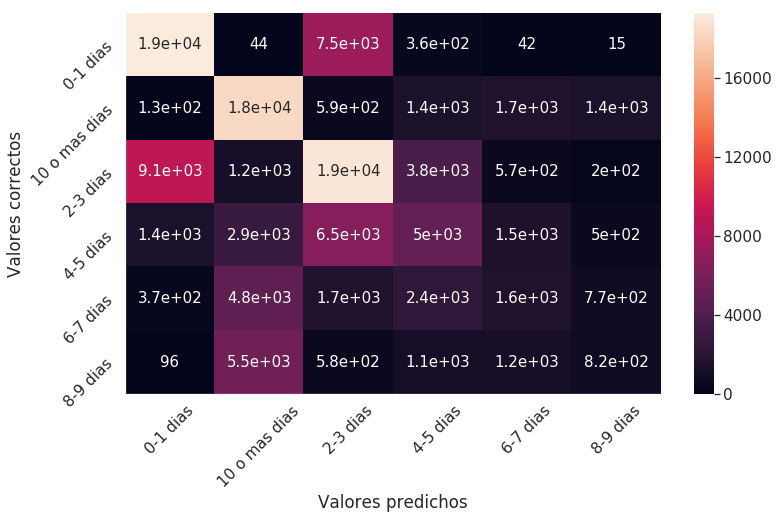

In [0]:
plt.figure(figsize=(12,7))
seaborn.set(font_scale=1.4)
seaborn.heatmap(df_cm, annot=True,annot_kws={"size": 15},xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.xlabel('Valores predichos')
plt.ylabel('Valores correctos')
seaborn.despine()

La matrix de confusión la podemos leer como por ejemplo:

Hay 44 valores que corresponden a la clase 0-1 días, para los cuáles se predijo un valor de 10 o más días.
Hay 42 valores que corresponden a la clase 0-1días, pero que se predijieron para la clase 6-7 días
Hay 15 valores que corresponden a la clase 0-1dias días, pero que se predijieron para la clase 8-9 días.

In [0]:
dataset_clean.shape

(492881, 14)

A continuación seleccionamos otros features (service, receiver_state_le), para ver como se comporta knn y ver si la elección de los features mejora.

In [0]:
X = dataset_clean[['service','receiver_state_le']]
y = dataset_clean['shipment_days_byclass']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
n_neighbors = 5
 
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.47
Accuracy of K-NN classifier on test set: 0.47


El accuracy es mas bajo que el obtenido anteriormente, por ende nos podemos quedar con la primer selección de features(service, receiver_zipcode).

In [0]:
y_pred = knn.predict(X_test)

In [0]:
print(confusion_matrix(y_test, y_pred))  

[[23714    40  2545   930     7     0]
 [  282 17638   174  4422   663   361]
 [16005  1172  9742  6679   182     6]
 [ 3335  3240  4585  6154   526    17]
 [  919  5044  1281  3484   664   142]
 [  310  5740   343  2217   482   176]]


In [0]:
print(classification_report(y_test, y_pred))  

               precision    recall  f1-score   support

     0-1 dias       0.53      0.87      0.66     27236
10 o mas dias       0.54      0.75      0.63     23540
     2-3 dias       0.52      0.29      0.37     33786
     4-5 dias       0.26      0.34      0.29     17857
     6-7 dias       0.26      0.06      0.09     11534
     8-9 dias       0.25      0.02      0.04      9268

     accuracy                           0.47    123221
    macro avg       0.39      0.39      0.35    123221
 weighted avg       0.44      0.47      0.42    123221



In [0]:
cm = confusion_matrix(y_test, y_pred)

In [0]:
df_cm = pandas.DataFrame(cm, range(6),
                  range(6))

In [0]:
classes = dataset_clean['shipment_days_byclass'].unique()
classes.sort()
classes

array(['0-1 dias', '10 o mas dias', '2-3 dias', '4-5 dias', '6-7 dias',
       '8-9 dias'], dtype=object)

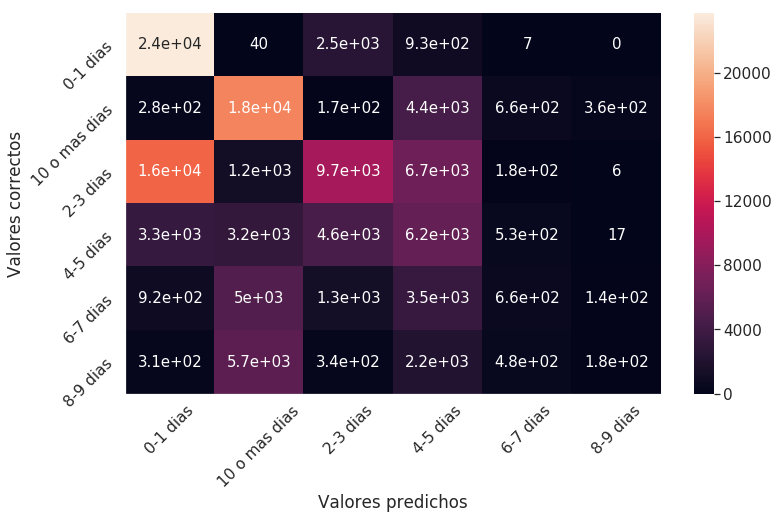

In [0]:
plt.figure(figsize=(12,7))
seaborn.set(font_scale=1.4)
seaborn.heatmap(df_cm, annot=True,annot_kws={"size": 15},xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.xlabel('Valores predichos')
plt.ylabel('Valores correctos')
seaborn.despine()



Comparando los accuracy, entre las 2 clasificaciones la que resulta mejor es la primera que fue con los features: service, receiver_zipcode. La segunda prueba fue con los features: service, receiver_state_le.

Y por ultimo probemos con los features service, receiver_state_le y receiver_zipcode para ver si se mejora el accuracy:

In [0]:
X = dataset_clean[['service','receiver_state_le','receiver_zipcode']]
y = dataset_clean['shipment_days_byclass']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
n_neighbors = 5
 
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.58
Accuracy of K-NN classifier on test set: 0.52


Agregando un feature más no encontramos que hayamos mejorado el accuracy, por ende nos alcanza con los features service, receiver_zipcode. También podemos notar que receiver_state_le y receiver_zipcode tienen codificada la misma información, ese debe ser el porque no esta sumando.

In [0]:
y_pred = knn.predict(X_test) # borraria

In [0]:
print(confusion_matrix(y_test, y_pred))  # borraria

[[18996    94  7550   521    59    16]
 [  176 17701   853  1326  1587  1897]
 [ 9767  1517 17979  3731   578   214]
 [ 1784  3427  6433  4432  1266   515]
 [  499  4923  1919  2068  1248   877]
 [  168  5497   755  1010   912   926]]


In [0]:
print(classification_report(y_test, y_pred))  # borraria

               precision    recall  f1-score   support

     0-1 dias       0.61      0.70      0.65     27236
10 o mas dias       0.53      0.75      0.62     23540
     2-3 dias       0.51      0.53      0.52     33786
     4-5 dias       0.34      0.25      0.29     17857
     6-7 dias       0.22      0.11      0.15     11534
     8-9 dias       0.21      0.10      0.14      9268

     accuracy                           0.50    123221
    macro avg       0.40      0.41      0.39    123221
 weighted avg       0.46      0.50      0.47    123221



In [0]:
cm=confusion_matrix(y_test, y_pred) # borraria

In [0]:
df_cm = pandas.DataFrame(cm, range(6), range(6)) # borraria

In [0]:
classes=dataset_clean['shipment_days_byclass'].unique() # borraria
classes.sort()
classes

array(['0-1 dias', '10 o mas dias', '2-3 dias', '4-5 dias', '6-7 dias',
       '8-9 dias'], dtype=object)

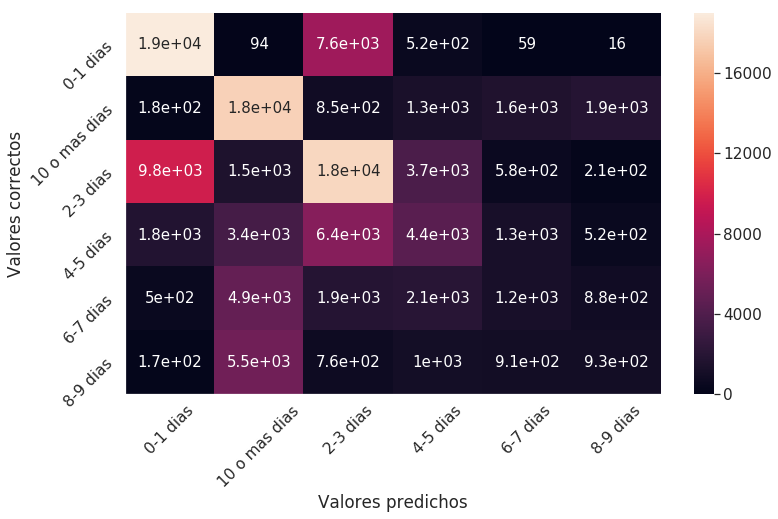

In [0]:
plt.figure(figsize=(12,7)) # borraria
seaborn.set(font_scale=1.4)
seaborn.heatmap(df_cm, annot=True,annot_kws={"size": 15},xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.xlabel('Valores predichos')
plt.ylabel('Valores correctos')
seaborn.despine()

Conclusión:

En la primera selección de features (service y receiver_zipcode) y en la última (service, receiver_zipcode y receiver_state) estamos obteniendo el mismo accuracy, por ende se podría usar la primera porque tiene menos cantidad de features. 
La segunda (service, receiver_state) al tener un mas bajo accuracy descartamos esa selección de features para un futuro. 
En un futuro podríamos probar con otros features, para ver si mejora KNN.
Cabe aclarar que no sólo deberíamos ver el accuracy, sino también la matriz de confusión que deberíamos encontrar lo más parecido a tener en la diagonal valores altos, y en el resto de la matriz valores cercanos a 0.

Desde nuestro punto de vista como data scientist al ver la matriz de confusión y el accuracy respectivo podemos aconsejar no usar este modelo.
Pensamos que usar receiver_zipcode o receive_state obtuvimos el mismo accuracy porque ambas estarían codificando la misma información, que sería la ubicación del comprador.

Igual comparado con otros resultados (de ejemplos de otros data set) consideramos que knn con nuestros datos no estamos obteniendo los resultados esperados. 
A un futuro podríamos utilizar otros clasificadores automáticos o no.

También en dicho informe se realizó un análisis de los datos donde se identificó datos duplicados, que en este práctico fueron eliminados, pero en un futuro no se borrarían, dado que no contamos con la información suficiente para decir que no son datos de dos envíos iguales.
En la segunda clasificación se usó el modelo con la variable receiver_state codificada, pero no se obtuvieron resultados mejores, dado que dicha variable estaría codificando la misma información que receiver_zipcode.
Se hizo un pequeño análisis de que features principales son mejores para nosotras como data scientits, pero en un futuro podríamos probar con mas features. 
